# Predictive Analytics - BITCOIN Historical Datasets 2018-2025

---
By: Rahmi Amilia



## 1. Business Understanding

🔍 Problem Statement
Bagaimana cara memprediksi harga penutupan harian Bitcoin secara akurat dengan menggunakan data historis, agar dapat digunakan dalam pengambilan keputusan investasi atau perdagangan?

🎯 Goals
Membangun model machine learning yang mampu memprediksi harga penutupan Bitcoin (Close) berdasarkan data historis seperti Open, High, Low, dan Volume.

💡 Solution Statement
Untuk mencapai tujuan tersebut, digunakan dua pendekatan utama:

Model klasik:
* Menggunakan algoritma regresi seperti RandomForestRegressor, XGBRegressor, dan SVR untuk membangun model prediksi.

Model deep learning:
* Menggunakan algoritma LSTM (Long Short-Term Memory) yang dirancang khusus untuk menangani data berurutan atau time series, seperti pergerakan harga.

Semua model yang dibangun dievaluasi menggunakan metrik performa:

* MAE (Mean Absolute Error)

* MSE (Mean Squared Error)

* R² Score (Koefisien Determinasi)

Model dengan performa terbaik akan digunakan untuk memprediksi harga Bitcoin di masa mendatang.

## 2. Data Understanding

Dataset ini diambil dari [Kaggle: Bitcoin Historical Data](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data). Dataset ini berisi data historis perdagangan Bitcoin dalam interval waktu tertentu.

Kumpulan data ini berisi data harga historis untuk Bitcoin (BTC/USDT) dari 1 Januari 2018 hingga saat ini. Data tersebut bersumber menggunakan API Binance, yang menyediakan data candlestick terperinci dalam empat kerangka waktu:

*   15-minute (15M)
*   1-hour (1H)
*   4-hour (4H)
*   1-day (1D)

Kumpulan data ini mencakup bidang-bidang berikut untuk setiap jangka waktu:
*   Open Time : Stempel waktu saat interval dimulai
*   Open : Harga Bitcoin di awal interval
*   High : Harga tertinggi selama interval
*   Low : Harga terendah selama interval
*   Close : Harga Bitcoin di akhir interval
*   Volume : Volume perdagangan selama interval
*   Close time : Stempel waktu saat interval ditutup
*   Quote asset volume : Total volume aset kutipan yang diperdagangkan selama interval
*   Number of trades : Jumlah perdagangan yang dieksekusi dalam interval
*   Take buy base asset volume : Volume aset dasar yang dibeli oleh taker
*   Take buy quote asset volume : Volume aset kutipan yang dibelanjakan oleh taker

Dataset ini tidak memiliki nilai kosong atau duplikat yang signifikan, dan telah diperiksa untuk korelasi antar fitur sebelum digunakan dalam pemodelan.

### 3. Import Library

Import semua library yang dibutuhkan untuk proses data preparation, visualisasi, dan pemodelan.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

### 4. Load Dataset
Memuat dataset historis harga Bitcoin dari file CSV. Dataset ini mencakup informasi harga, volume, dan tanggal dari tahun 2018 hingga 2025

In [115]:
df = pd.read_csv('/content/btc_1d_data_2018_to_2025.csv')

In [116]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,2018-01-01 23:59:59.999,1.147997e+08,105595,3961.938946,5.280975e+07,0
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,1.580801e+08,0
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,1.335873e+08,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,1.861168e+08,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,2.118299e+08,0


In [117]:
print(df.describe)

<bound method NDFrame.describe of        Open time      Open      High       Low     Close        Volume  \
0     2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844   
1     2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111   
2     2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639   
3     2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574   
4     2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125   
...          ...       ...       ...       ...       ...           ...   
2670  2025-04-24  93691.07  93787.65  93060.75  93607.99   1498.312430   
2671  2025-04-25  93980.47  94444.00  93520.00  93664.14   2699.078200   
2672  2025-04-26  94638.68  95199.00  94527.84  95055.48   1878.899830   
2673  2025-04-27  94628.00  95369.00  94041.60  94222.29   3179.085700   
2674  2025-04-28  93749.29  93798.71  92800.01  93130.44   2221.763690   

                   Close time  Quote asset volume  Number of trades  \
0     

### 5. Data Cleaning & Feature Engineering

In [118]:
df['Open time'] = pd.to_datetime(df['Open time'])
df.drop(columns=['Ignore', 'Close time'], inplace=True, errors='ignore')
df['Mean_Price'] = (df['High'] + df['Low']) / 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open time                     2675 non-null   datetime64[ns]
 1   Open                          2675 non-null   float64       
 2   High                          2675 non-null   float64       
 3   Low                           2675 non-null   float64       
 4   Close                         2675 non-null   float64       
 5   Volume                        2675 non-null   float64       
 6   Quote asset volume            2675 non-null   float64       
 7   Number of trades              2675 non-null   int64         
 8   Taker buy base asset volume   2675 non-null   float64       
 9   Taker buy quote asset volume  2675 non-null   float64       
 10  Mean_Price                    2675 non-null   float64       
dtypes: datetime64[ns](1), float64(

In [119]:
print(df.columns)

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Mean_Price'],
      dtype='object')


In [120]:
print(df.tail())

      Open time      Open      High       Low     Close      Volume  \
2670 2025-04-24  93691.07  93787.65  93060.75  93607.99  1498.31243   
2671 2025-04-25  93980.47  94444.00  93520.00  93664.14  2699.07820   
2672 2025-04-26  94638.68  95199.00  94527.84  95055.48  1878.89983   
2673 2025-04-27  94628.00  95369.00  94041.60  94222.29  3179.08570   
2674 2025-04-28  93749.29  93798.71  92800.01  93130.44  2221.76369   

      Quote asset volume  Number of trades  Taker buy base asset volume  \
2670        1.399920e+08            173779                    429.75126   
2671        2.533782e+08            307401                   1518.80459   
2672        1.781277e+08            150054                    789.03707   
2673        3.014499e+08            394263                   1534.29285   
2674        2.071204e+08            436996                    991.34663   

      Taker buy quote asset volume  Mean_Price  
2670                  4.014164e+07    93424.20  
2671                  1.

In [121]:
print(df.head())

   Open time      Open      High       Low     Close        Volume  \
0 2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844   
1 2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111   
2 2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639   
3 2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574   
4 2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125   

   Quote asset volume  Number of trades  Taker buy base asset volume  \
0        1.147997e+08            105595                  3961.938946   
1        2.797171e+08            177728                 11346.326739   
2        2.361169e+08            162787                  8994.953566   
3        3.127816e+08            170310                 12680.812951   
4        3.693220e+08            192969                 13346.622293   

   Taker buy quote asset volume  Mean_Price  
0                  5.280975e+07   13284.275  
1                  1.580801e+08   14181.755  
2       

### 6. EDA - Exploratory Data Analysis

In [122]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open time                     2675 non-null   datetime64[ns]
 1   Open                          2675 non-null   float64       
 2   High                          2675 non-null   float64       
 3   Low                           2675 non-null   float64       
 4   Close                         2675 non-null   float64       
 5   Volume                        2675 non-null   float64       
 6   Quote asset volume            2675 non-null   float64       
 7   Number of trades              2675 non-null   int64         
 8   Taker buy base asset volume   2675 non-null   float64       
 9   Taker buy quote asset volume  2675 non-null   float64       
 10  Mean_Price                    2675 non-null   float64       
dtypes: datetime64[ns](1), float64(

*   *info()* untuk menunjukkan bahwa semua kolom memiliki tipe data yang numerik atau datetime
*   *isnull().sum()* apakah ada missing value kalau tidak ada missing, berarti datanya bersih

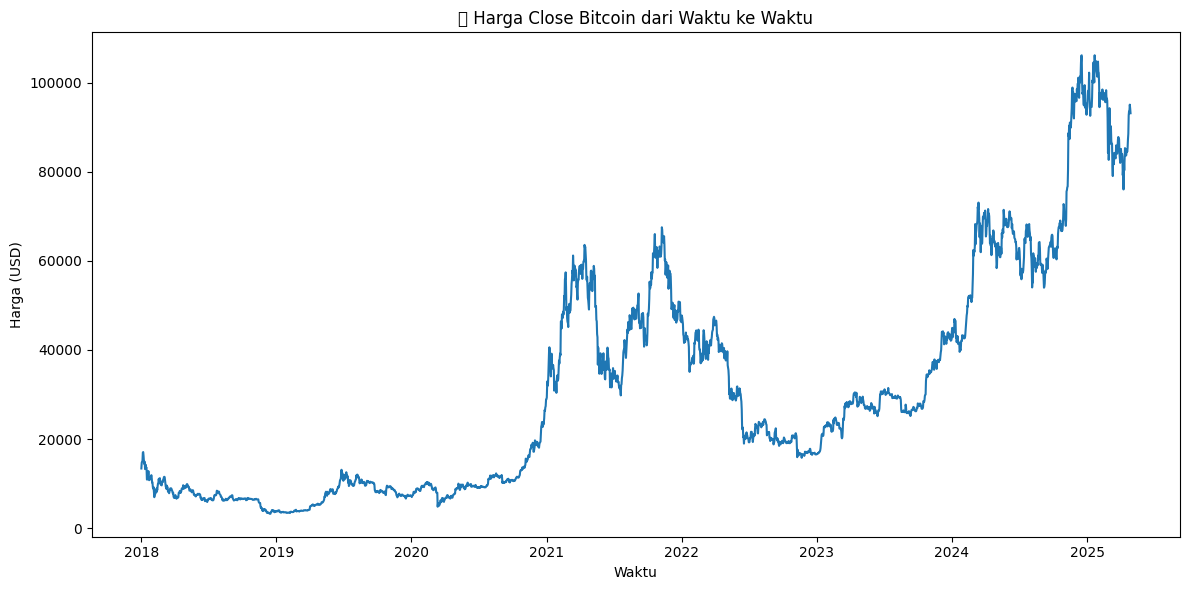

In [123]:
plt.figure(figsize=(12,6))
plt.plot(df['Open time'], df['Close'], label='Close Price')
plt.title('📈 Harga Close Bitcoin dari Waktu ke Waktu')
plt.xlabel('Waktu')
plt.ylabel('Harga (USD)')
plt.tight_layout()
plt.show()

*   Grafik di atas menunjukkan tren harga **Bitcoin** dari tahun ke tahun dan menunjukkan periode bullish (naik) dan bearish (turun), seperti lonjakan harga pada tahun 2021 dan penurunan berikutnya

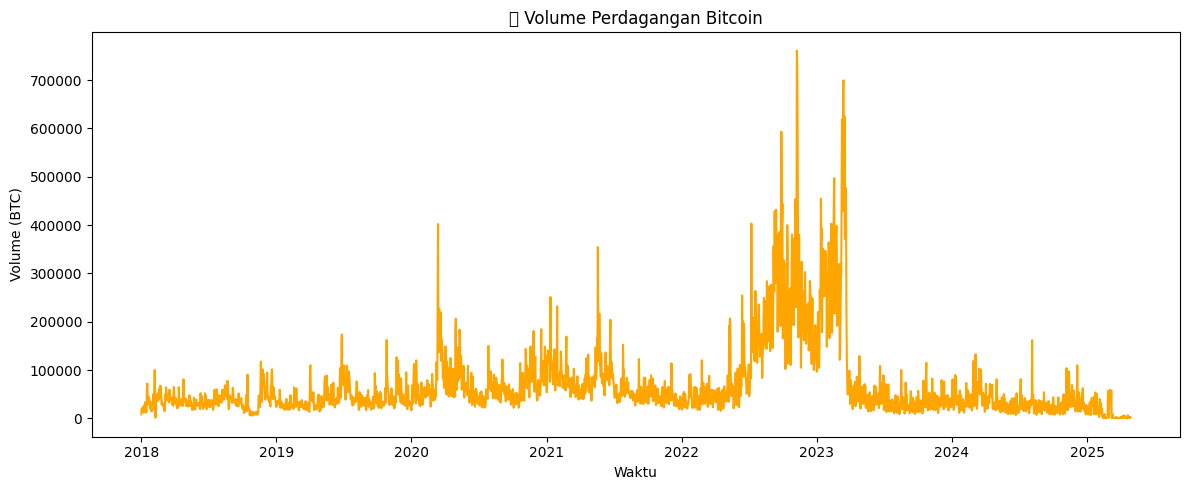

In [124]:
plt.figure(figsize=(12,5))
plt.plot(df['Open time'], df['Volume'], label='Volume', color='orange')
plt.title('🔁 Volume Perdagangan Bitcoin')
plt.xlabel('Waktu')
plt.ylabel('Volume (BTC)')
plt.tight_layout()
plt.show()

*   terlihat juga volume menunjukka seberapa aktif perdagangan Bitcoin, lonjakan volumenya terjadi ketika harga sangat naik dan sangat turun.

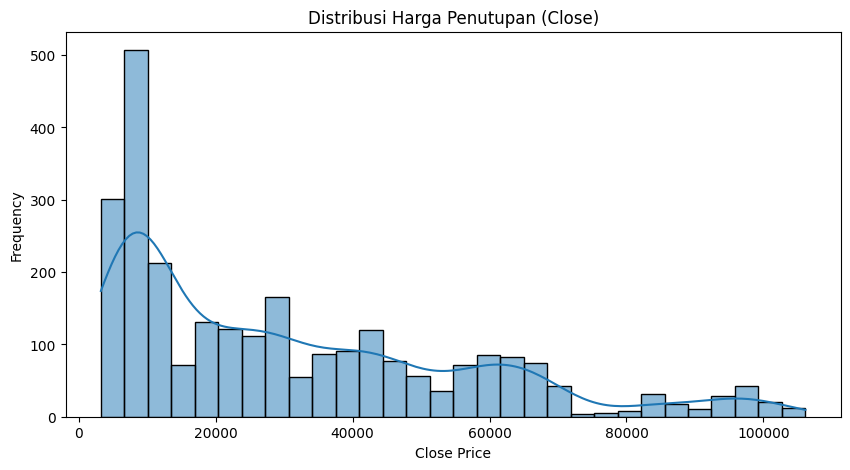

In [125]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], kde=True, bins=30)
plt.title('Distribusi Harga Penutupan (Close)')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

Distribusi harga penutupan Bitcoin yang divisualisasikan menunjukkan karakteristik sebagai berikut:
*   Distribusi Miring ke Kanan (Right-Skewed)

  Sebagian besar nilai harga penutupan berada di rentang rendah (sekitar 5.000 hingga 30.000), dan semakin sedikit data yang berada di rentang harga tinggi (di atas 60.000)
  menandakan bahwa mayoritas waktu dalam dataset, harga Bitcoin berada pada level yang lebih rendah dibandingkan dengan puncak harga tertinggi yang pernah tercapai
*   Puncak Histogram di Rentang 10.000–15.000

  Frekuensi paling tinggi berada pada harga penutupan sekitar 10.000–15.000, yang menunjukkan bahwa harga ini merupakan harga yang paling sering muncul dalam periode data yang digunakan

* Adanya Ekor Panjang ke Kanan

  Ekor distribusi memanjang hingga lebih dari 100.000, yang menunjukkan beberapa hari dalam data memiliki harga penutupan yang sangat tinggi. Ini kemungkinan mencerminkan masa-masa puncak harga Bitcoin seperti pada tahun 2021

* Volatilitas yang Tinggi

  Bentuk distribusi yang menyebar luas dan tidak simetris juga mengindikasikan tingkat volatilitas yang tinggi dalam harga penutupan Bitcoin, yang memang merupakan karakteristik umum dari pasar kripto



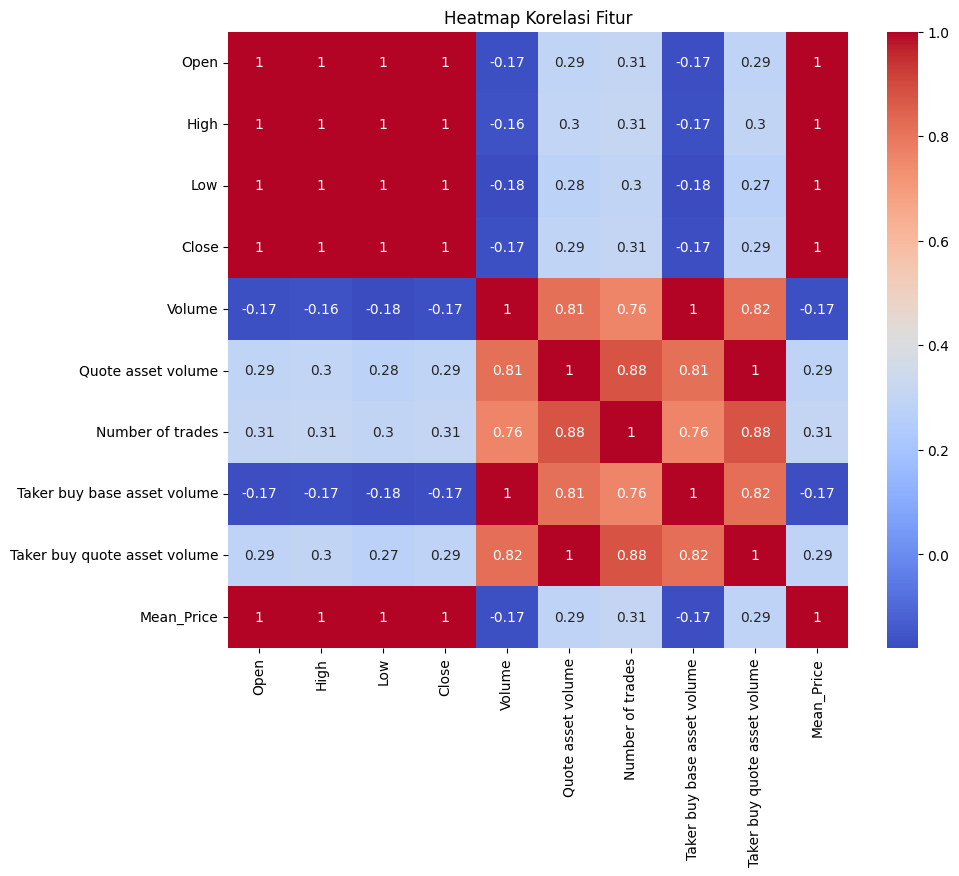

In [126]:
numeric_cols = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

*   Korelasi antara fitur nya seperti ini :
  * ***Close*** sangat berkorelasi dengan **Open**, **High**, **Low**, dan **Mean_price**
  * ***Taker Buy Volume*** juga memiliki korelasi yang cukup dengan **Volume** dan **Quote Asset Volume**

### 7. Data Preparation
Tahapan ini menyiapkan data sebelum pelatihan model, mencakup:
- Pemilihan fitur yang relevan
- Normalisasi nilai fitur
- Pembagian data menjadi training dan testing

In [127]:
df = df[['Open', 'High', 'Low', 'Volume', 'Close']]

Penghapusan nilai kosong

In [128]:
df = df.dropna()

Selanjutnya, pisahkan fitur dan target

In [129]:
X = df.drop('Close', axis=1)
y = df['Close']

Normalisasi fitur dengan MinMaxScaler

In [130]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Bagi data menjadi data latih dan uji tanpa mengacak urutan waktu

In [131]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")

Jumlah data train: 2140
Jumlah data test: 535


### 8. Model Development
Model yang digunakan dalam proyek ini adalah model Recurrent Neural Network (RNN) khususnya Long Short-Term Memory (LSTM). Alasan penggunaan LSTM adalah karena model ini cocok untuk memproses data runtun waktu seperti data harga Bitcoin yang bersifat time-series.

### Arsitektur Model
Model LSTM yang dikembangkan terdiri atas beberapa lapisan:
- **LSTM Layer**: Lapisan utama yang memproses sekuens data.
- **Dropout**: Untuk mencegah overfitting.
- **Dense Layer**: Lapisan keluaran untuk menghasilkan prediksi harga.


In [132]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [133]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 50)          │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Model dilatih menggunakan data pelatihan selama 50 epoch untuk mempelajari pola dari data historis harga Bitcoin.

Dengan model ini, diharapkan mampu menangkap dinamika harga Bitcoin dan memberikan prediksi yang akurat berdasarkan pola historis.

In [134]:
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 682244224.0000 - val_loss: 826600832.0000
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 691030848.0000 - val_loss: 826235840.0000
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 676147072.0000 - val_loss: 825762624.0000
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 702109312.0000 - val_loss: 825473088.0000
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 694156224.0000 - val_loss: 825260160.0000
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 660438464.0000 - val_loss: 825075328.0000
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 667927744.0000 - val_loss: 824905280.0000
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 694189504.0000 - val_loss: 824744384.0000
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 719846144.0000 - val_loss: 824586496.0000
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 674059456.0000 - val_loss: 824432384.000

Melakukan prediksi menggunakan model LSTM

In [135]:
lstm_pred = model.predict(X_test_reshaped)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Mengubah bentuk hasil prediksi menjadi 1 dimensi

In [136]:
lstm_pred = lstm_pred.reshape(-1)

### 9.Modeling

Cell ini akan menampilkan hasil evaluasi performa tiga model regresi yang digunakan untuk memprediksi nilai numerik seperti besar harga, nilai pasar maupun variabel kontinu.

Evaluasi dilakukan menggunaka tiga metrik, seperti :
*   ***MAE (Mean Absolute Error)***: Mengukur rata-rata absolut dari selisih antara nilai prediksi dan nilai aktual. Semakin kecil nilai MAE, semakin baik performa model
*   ***RMSE (Root Mean Squared Error)***: Mengukur akar kuadrat dari rata-rata kuadrat selisih antara prediksi dan aktual. Ini memberikan penalti lebih besar pada kesalahan besar
*   ***R² Score (Koefisien Determinasi)***: Mengukur seberapa baik model menjelaskan varians dari data. Nilai R² = 1 artinya model sangat baik, sedangkan R² < 0 menunjukkan model lebih buruk dari rata-rata.

8.1 Random Forest Regressor

Model yang terbaik berdasarkan ketiga metrik evaluasi

In [137]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

8.2 XGBRegressor

Yang memiliki performa mendekati Random Forest, tetapi sedikit lebih buruk

In [138]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

8.3 SVR

sangat tidak direkomendasikan untuk digunakan pada dataset ini tanpa melakukan tuning

In [139]:
svr_model = SVR(kernel='rbf', C=100)
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

### 10. Evaluation
Evaluasi model dilakukan dengan menghitung metrik error yang umum digunakan pada regresi yaitu:

*   MAE (Mean Absolute Error)
*   RMSE (Root Maen Squared Error)
* R² Score (Koefisien Determinasi)
* LSTM (Long Short-Term Memory)

Serta visualisasi hasil prediksi vs aktual untuk melihat seberapa baik model memprediksi harga Bitcoin.

In [140]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f" {model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print("-" * 30)

In [141]:
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, svr_pred, "SVR")
evaluate_model(y_test, lstm_pred, "LSTM")

 Random Forest Performance:
MAE: 9179.32
RMSE: 15520.82
R2 Score: 0.33
------------------------------
 XGBoost Performance:
MAE: 10122.21
RMSE: 16573.84
R2 Score: 0.23
------------------------------
 SVR Performance:
MAE: 32494.02
RMSE: 41278.32
R2 Score: -3.76
------------------------------
 LSTM Performance:
MAE: 69058.54
RMSE: 71601.79
R2 Score: -13.33
------------------------------


* Hasil Evaluasi dari*** Random Fores***t memiliki performa terbaik dari ketiga model, meskipun R² hanya menunjukkan kontribusi 33% dalam menjelaskan variabilitas data
* Maupun hasil dari ***XGBoost*** juga termasuk performa yang layak, walaupun sedikit lebih buruk dibandingkan dengan Random Forest
* dan terakhir performa dari ***SVR*** sangat buruk dikarenakan R² negatif yang menandakan bahwa model tidak mampu menangkap pola data sama sekali dan lebih buruk dari prediksi rata-rata

### 11. Visualization

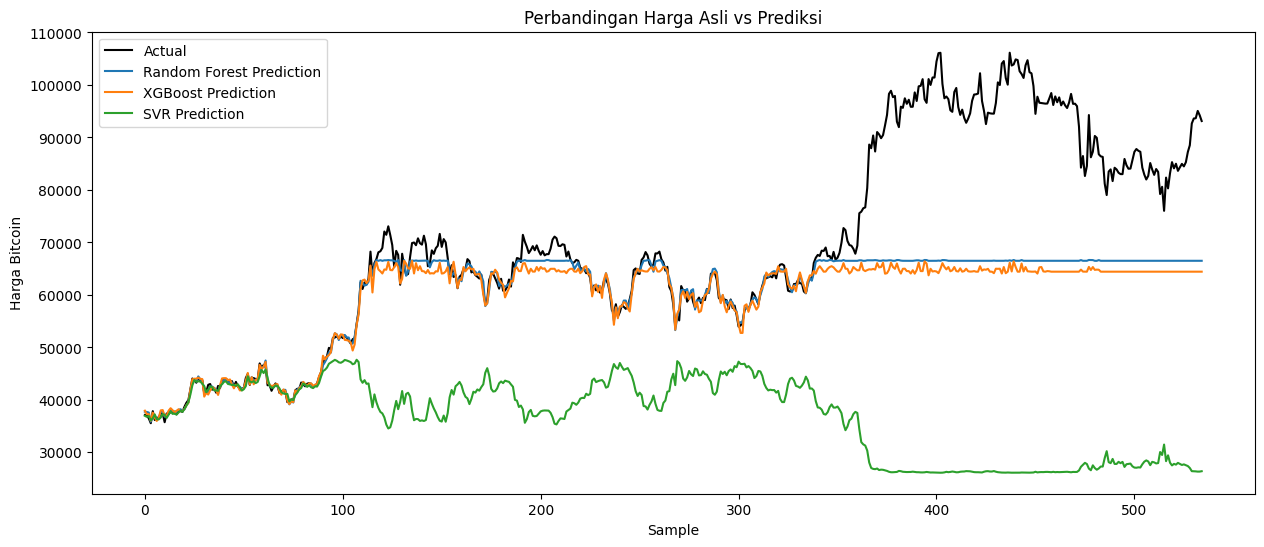

In [142]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(rf_pred, label='Random Forest Prediction')
plt.plot(xgb_pred, label='XGBoost Prediction')
plt.plot(svr_pred, label='SVR Prediction')
plt.legend()
plt.title('Perbandingan Harga Asli vs Prediksi')
plt.xlabel('Sample')
plt.ylabel('Harga Bitcoin')
plt.show()

Hasil dari Perbandingan Harga Asli & Prediksi
1.   Random Forest Prediction (garis biru)
  *   Kecocokan dengan data asli cukup baik pada sebagian besar area data, terutama sebelum lonjakan besar harga Bitcoin.
  *   Masih merupakan prediksi terbaik secara visual dibandingkan dua model lainnya
2.   XGBoost Prediction (garis oranye)
  *   sedikit lebih underfit di beberapa bagian
  *   pada titik pertengahan (sekitar sample ke-300), prediksi mulai melemah secara visual terhadap fluktuasi harga asli, dan itu pun cenderung "Flat"
3. SVR Prediction (garis hijau)
  *   Prediksi nya sangat jauh dari data aktual
  *   Tidak menangkap tren atau fluktuasi harga sama sekali, walupun seperti terjebak di bawah nilai rata-rata lalu kemudian menjadi stagnan
  * terlalu jelas juga bahwa model ini underfitting ekstream dan tidak cocok digunakan untuk dataset dalam kondisi saat ini

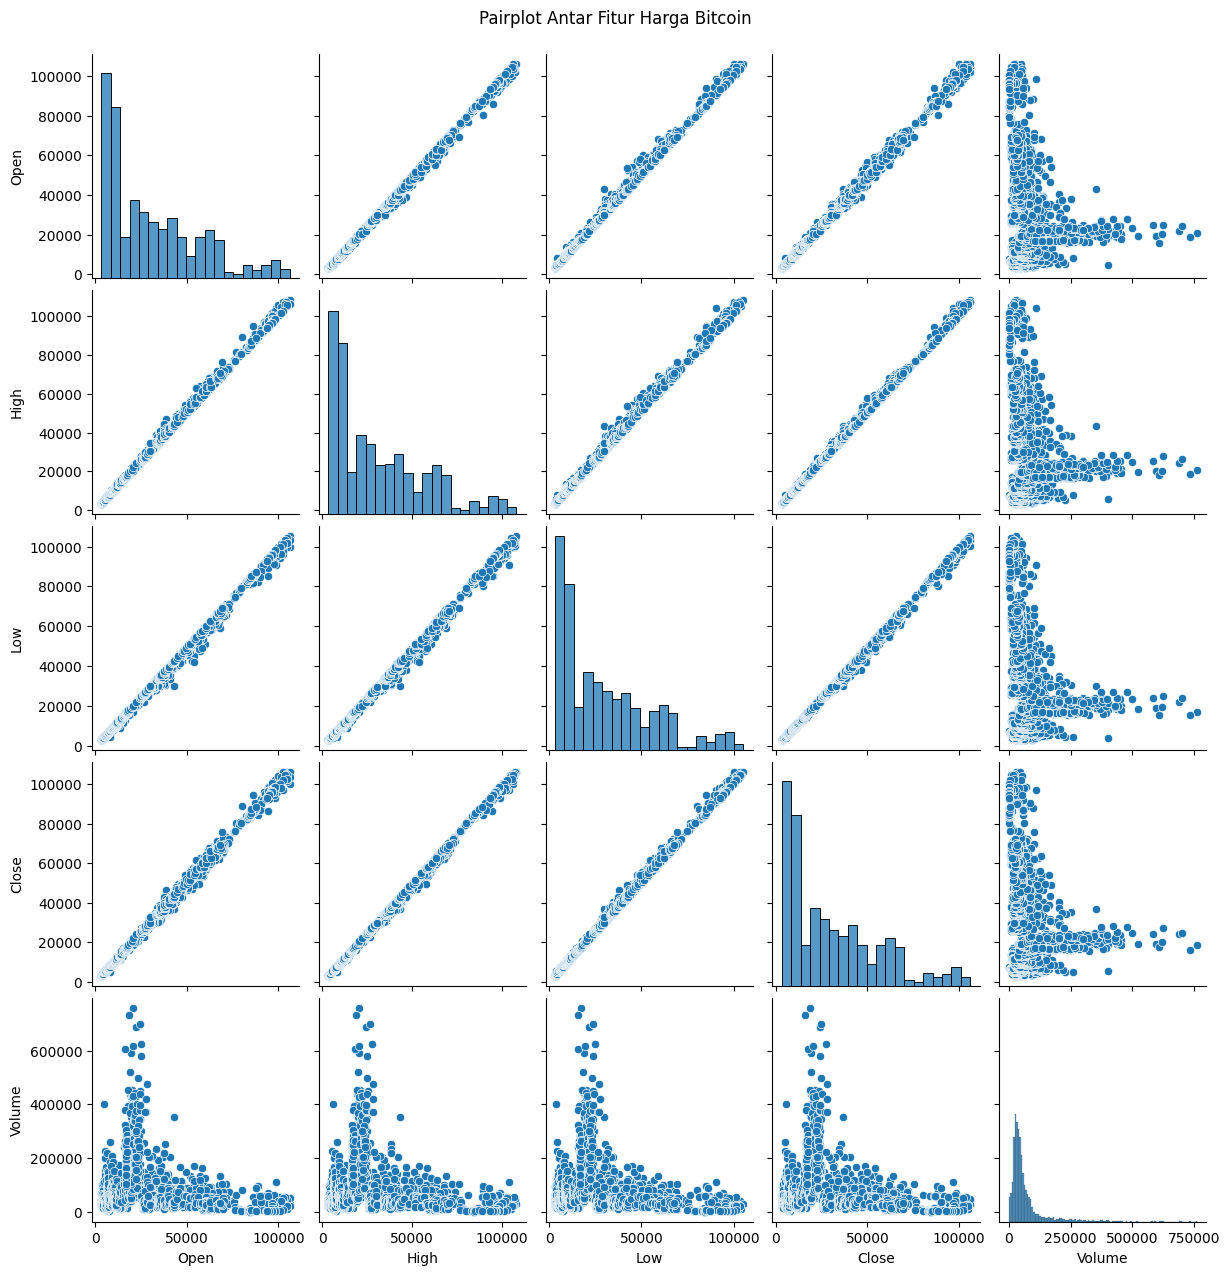

In [143]:
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pairplot Antar Fitur Harga Bitcoin', y=1.02)
plt.show()

Pairplot adalah visualisasi eksploratif untuk melihat :
*   Hubungan antar variable numerik melalui scatter plot (diagram sebar)
*   Distribusi tiap variable melalui histogram (diagonal utama)

Fitur yang digunakan Pairplot:
*   'Open' : Harga saat pembukaan pasar
*   'High' : Harga tertinggi dalam satu hari
* 'Low' : Harga terendah dalam satu hari
* 'Close' : Harga penutupan
* 'Volume' : Volume transaksi (jumlah bitcoin yang diperdagangkan)

Berikut analisis Visual dari Plot:
1. Korelasi Kuat antar Harga (Open, High, Low, Close):
  *  Scatter plot antara Open, High, Low, dan Close membentuk pola linear sangat kuat
  * yang artinya, jika salah satu naik, maka yang lain cenderung ikut naik — ini wajar dan diharapkan dalam data harga saham/kripto
  * Korelasi seperti ini mengindikasikan bahwa model tidak perlu menggunakan keempat fitur secara bersamaan kecuali dilakukan transformasi lebih lanjut (misalnya: selisih harian atau rata-rata harian)
2. Volume Tidak Berkorelasi Erat dengan Harga:
  * Scatter plot antara Volume dan harga (Open, High, Low, Close) menunjukkan sebaran acak dan tidak membentuk pola linear yang jelas
  * Menunjukkan bahwa Volume tidak memiliki korelasi langsung dengan harga, atau hubungan antara Volume dan harga bersifat non-linear atau kompleks
3. Distribusi Histogram:
  * Distribusi Open, High, Low, dan Close menunjukkan bentuk mirip, dengan konsentrasi besar di kisaran harga rendah
  * Distribusi Volume terlihat lebih menyebar dan tidak normal, yang mengindikasikan adanya outlier atau fluktuasi besar dalam volume perdagangan
